# Machine learning for genetic data

## Introduction

The goal of this practical session is to manipulate high-dimensional, low sample-size data that is typical of many genetic applications.

Here we will work with GWAS data from _Arabidopsis thaliana_, which is a plant model organism. The genotypes are hence described by **Single Nucleotide Polymorphisms, or SNPs**. Our goal will be to use this data to identify regions of the genome that can be linked with various growth and flowering traits (**phenotypes**).

## Data description

* `data/athaliana_small.X.txt` is the design matrix. As many rows as samples, as many columns as SNPs
* the SNPs are given (in order) in `data/athaliana_small.snps.txt`. 
* the samples are given (in order) in `data/athaliana.samples.txt`.

* the phenotypes are given in `data/phenotypes.pheno`. The first two columns give the sample's ID, and all following columns give a phenotype. The header gives the list of all phenotypes. In this session we will use "2W" and "4W", which give the number of days by which the plant grows to be 5 centimeters tall, after either two weeks ("2W") or four weeks ("4W") of vernalization (i.e. the seeds are kept at cold temperatures, similar to winter). Not all phenotypes are available for all samples.

* `data/athaliana.snps_by_gene.txt` contains, for each _A. thaliana_ SNP, the list of genes it is in or near to. (This can be several genes, as it is customary to use a rather large window to compute this, so as to capture potential cis-regulatory effects.)

* the feature network is in `data/athaliana_small.W.txt`. It has been saved as 3 arrays, corresponding to the row, col, and data attributes of a [scipy.sparse coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html).

## Loading the data

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Read the list of SNP names

In [2]:
with open('data/athaliana_small.snps.txt') as f:
    snp_names = f.readline().split()
    f.close()
print(len(snp_names), snp_names[:10])

9419 ['Chr1_21043_T', 'Chr1_21128_T', 'Chr1_21829_C', 'Chr1_22522_G', 'Chr1_27265_C', 'Chr1_29291_A', 'Chr1_31515_G', 'Chr1_32807_A', 'Chr1_35856_C', 'Chr1_37072_G']


#### Read the list of sample names

In [3]:
samples = list(np.loadtxt('data/athaliana.samples.txt', # file names
                         dtype=int)) # values are integers
print(len(samples), samples[:10])

1307 [9381, 9380, 9378, 9371, 9367, 9363, 9356, 9355, 9354, 9353]


#### Load the design matrix (n samples x p SNPs)

In [4]:
X = np.loadtxt('data/athaliana_small.X.txt',  # file names
               dtype='int') # values are integers

In [5]:
n, p = X.shape

In [6]:
len(np.where(X[0, :]==1)[0])

2685

#### Load the 2W phenotype data

The first phenotype we will work with is called "2W". It describes the number of days required for the bolt height to reach 5 cm, at a temperature of 23°C under 16 hours of daylight per 24 hours, for seeds that have been vernalized for 2 weeks at 5°C (with 8 hours of daylight per 24 hours).

In [7]:
import pandas as pd

In [215]:
# TODO
# read phenotypes from phenotypes.pheno
# only keep samples that have a 2W phenotype. 

df = pd.read_csv('data/phenotypes.pheno', sep=' ')
df_2W = df['2W']
samples_with_phenotype = np.where(pd.isnull(df_2W)!=True)[0]

In [9]:
# Restrict X to the samples with a 2W phenotype, in correct order
# X_2W[i] = X[samples.index(samples_with_phenotype[i])]
X_2W = X[samples_with_phenotype, :]
y_2W = np.array(df_2W)[samples_with_phenotype]
n, p = X_2W.shape
print(n, p)

152 9419


## Split the data in a train and test set

We will set aside a test set, containing 20% of our samples, on which to evaluate the quality of our predictive models.

In [10]:
from sklearn import model_selection

In [11]:
X_2W_tr, X_2W_te, y_2W_tr, y_2W_te = \
    model_selection.train_test_split(X_2W, y_2W, test_size=0.2, 
                                     random_state=17)
print(X_2W_tr.shape, X_2W_te.shape)

(121, 9419) (31, 9419)


## Visualize the phenotype

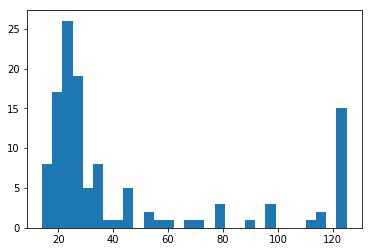

In [12]:
h = plt.hist(y_2W_tr, bins=30)

## T-test

Let us start by running a statistical test for association of each SNP feature with the phenotype.

In [13]:
import statsmodels.api as sm

In [14]:
p = X_2W_tr.shape[1]

In [15]:
pvalues = []
for snp_idx in range(p):
    # only look a the column corresponding at that SNP
    X_snp = X_2W_tr[:, snp_idx]
    # run a linear regression (with bias) between the phenotype and 
    # this SNP
    X_snp = sm.add_constant(X_snp)
    est = sm.regression.linear_model.OLS(y_2W_tr, X_snp)
    est2 = est.fit()
    # get the p-value from the model 
    pvalues.append(est2.pvalues[1])
pvalues = np.array(pvalues)

### Manhattan plot

The common way to visualize such results is by using a Manhattan plot: we will plot all SNPs on the x-axis, and on the y-axis we'll have the opposite of the log base 10 of the p-value. The lower the p-value, the higher the corresponding marker. 

We will also add a horizontal line that corresponds to the _threshold for significance_. Because we are testing multiple hypotheses, we need to lower our threshold accordingly. We will use __Bonferroni correction__ and divide the significance threshold (say, alpha=0.05) by the number of tests, that is, the number of SNPs p.

(0, 9419)

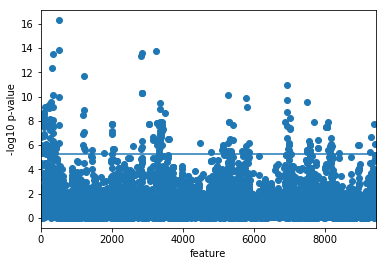

In [16]:
plt.scatter(range(p), # x = SNP position
            -np.log10(pvalues)) # y = -log10 p-value 

# significance threshold according to Bonferroni correction
t = -np.log10(0.05/p)
plt.plot([0, p], [t, t])

# plot labels
plt.xlabel("feature")
plt.ylabel("-log10 p-value")
plt.xlim([0, p])

__What do you observe? Are any SNPs significantly associated with the phenotype? What genes are they in/near?__

## Linear regression 

In [17]:
from sklearn import linear_model

In [18]:
model_lr = linear_model.LinearRegression(fit_intercept=True)
model_lr.fit(X_2W_tr, y_2W_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

(0, 9419)

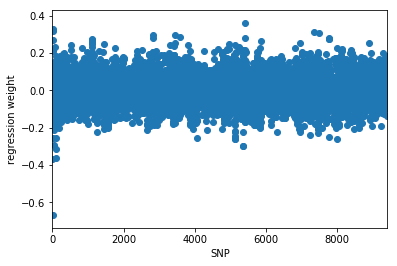

In [19]:
plt.figure(figsize=(6, 4))
plt.scatter(range(p), # x = SNP position
            model_lr.coef_)  # y = regression weights

plt.xlabel("SNP")
plt.ylabel("regression weight")
plt.xlim([0, p])

__What do you observe? How can you interpret these results? Do any of the SNPs strike you as having a strong influence on the phenotype?__

### Model predictive power

In [20]:
from sklearn import metrics

In [21]:
y_2W_lr_pred = model_lr.predict(X_2W_te)

print("Percentage of variance explained (using all SNPs): %.2f" % \
    metrics.explained_variance_score(y_2W_te, y_2W_lr_pred))

Percentage of variance explained (using all SNPs): 0.74


(9.0, 130.0)

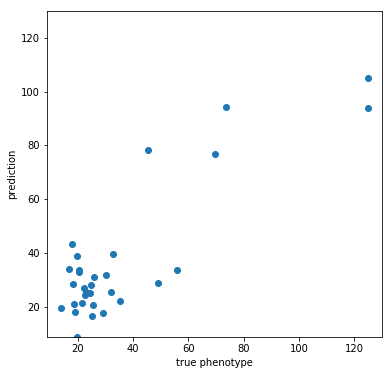

In [22]:
plt.figure(figsize=(6, 6))
plt.scatter(y_2W_te, y_2W_lr_pred)

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_te)-5, np.max(y_2W_te)+5])
plt.ylim([np.min(y_2W_te)-5, np.max(y_2W_te)+5])

## Lasso

In [23]:
alphas = np.logspace(-4., 1., num=20)

In [24]:
lasso = linear_model.Lasso(fit_intercept=True)
model_l1 = model_selection.GridSearchCV(lasso, 
                                        param_grid={'alpha': alphas}, 
                                        scoring='explained_variance')
model_l1.fit(X_2W_tr, y_2W_tr)

/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-04, 1.83298e-04, 3.35982e-04, 6.15848e-04, 1.12884e-03,
       2.06914e-03, 3.79269e-03, 6.95193e-03, 1.27427e-02, 2.33572e-02,
       4.28133e-02, 7.84760e-02, 1.43845e-01, 2.63665e-01, 4.83293e-01,
       8.85867e-01, 1.62378e+00, 2.97635e+00, 5.45559e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='explained_variance', verbose=0)

(0, 9419)

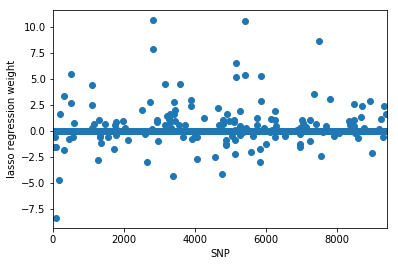

In [25]:
plt.figure(figsize=(6, 4))
plt.scatter(range(p), # x = SNP position
            model_l1.best_estimator_.coef_)  # y = regression weights

plt.xlabel("SNP")
plt.ylabel("lasso regression weight")
plt.xlim([0, p])

__How can you interpret these results? How many SNPs contribute to explaining the phenotype?__

In [249]:
print("%d SNPs selected." % \
    np.nonzero(model_l1.best_estimator_.coef_)[0].shape)
l1_selected_genes = np.where(model_l1.best_estimator_.coef_!=0)[0].tolist()

170 SNPs selected.


### Predictive power 

In [27]:
y_2W_l1_pred = model_l1.best_estimator_.predict(X_2W_te)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
     (np.nonzero(model_l1.best_estimator_.coef_)[0].shape[0], 
      metrics.explained_variance_score(y_2W_te, y_2W_l1_pred)))

Percentage of variance explained (using 170 SNPs): 0.60


(13.95, 125.05)

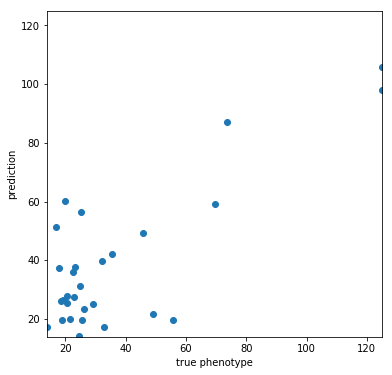

In [28]:
plt.figure(figsize=(6, 6))
plt.scatter(y_2W_te, y_2W_l1_pred)

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_te)-0.05, np.max(y_2W_te)+0.05])
plt.ylim([np.min(y_2W_te)-0.05, np.max(y_2W_te)+0.05])

### Stability

__How stable is the set of selected SNPs, between the different rounds of cross-validation with optimal parameters?__

You can use [sklearn.metrics.jaccard_similarity_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_similarity_score.html), or implement Kuncheva's consistency index.

In [30]:
def compute_stability(stability, selected_features):
    #all_selected_features = []
    #for j in range(nb_fold):
        # WARNING: list concatenation with '+' works only with Python3
    #    all_selected_features.append(np.where(selected_features[j]!=0)[0].tolist())
    #all_selected_features = list(np.union1d(all_selected_features))
    for j in range(nb_fold):
        selected_features[j] = np.where(selected_features[j]!=0)[0]
    return stability + [[float(len(np.intersect1d(selected_features[j], selected_features[k]))) / float(len(np.union1d(selected_features[j], selected_features[k])))
                         for j in range(nb_fold-1) for k in range(j+1,nb_fold)]]

def get_selected_feature(selected_features, coef):
    if len(coef.shape) > 1:  # for MT feature selection
        coef = coef[0,:]
    mask_coef = np.zeros(len(coef))
    mask_coef[np.where(coef!=0)[0]] = 1
    return selected_features + [mask_coef]
    

In [31]:
from sklearn import model_selection

random_states = [92,501,13,98,173,803,455,2948,999,234]
stability = []
nb_fold = 3
for i in range(3):
    kf = model_selection.KFold(n_splits=nb_fold, shuffle=True, random_state=random_states[i])
    kf.get_n_splits(X_2W_tr)
    selected_features = []
    for train_index, test_index in kf.split(X_2W_tr):
        coef = linear_model.Lasso(alpha=model_l1.best_params_['alpha'], fit_intercept=True, max_iter=5000).fit(
            X_2W_tr[train_index,:], y_2W_tr[train_index]).coef_
        selected_features = get_selected_feature(selected_features, coef)
    stability = compute_stability(stability, selected_features)
    
print(np.mean(stability))

0.08149899878689994


__Note:__ One could also contemplate using the Jaccard similarity (or another measure of consistency/stability/robustness) as a criterion to select the best hyperparameters. Pay attention, however, to the fact that hyperparameters selecting no features at all or all the features will have very good consistency.

In [32]:
list_stability, list_nb_selected_features = [], []
for alpha in alphas:
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=92)
    kf.get_n_splits(X_2W_tr)
    nb_selected_features, selected_features, stability = [], [], []
    for train_index, test_index in kf.split(X_2W_tr):
        coef = linear_model.Lasso(alpha=alpha, fit_intercept=True).fit(
            X_2W_tr[train_index,:], y_2W_tr[train_index]).coef_
        selected_features = get_selected_feature(selected_features, coef)
        nb_selected_features.append(len(np.where(coef!=0)[0]))
    stability = compute_stability(stability, selected_features)
    list_stability.append(np.mean(stability))
    list_nb_selected_features.append(np.mean(nb_selected_features))

/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [33]:
ind_sort = np.argsort(list_stability)[::-1]
for ind in ind_sort:
    print('alpha: %0.4f ; nb selected features: %i ; stability of feature selection: %0.4f' % \
          (alphas[ind], list_nb_selected_features[ind], list_stability[ind]))

alpha: 10.0000 ; nb selected features: 1 ; stability of feature selection: 0.6667
alpha: 0.0001 ; nb selected features: 1621 ; stability of feature selection: 0.3980
alpha: 0.0002 ; nb selected features: 1316 ; stability of feature selection: 0.3475
alpha: 5.4556 ; nb selected features: 11 ; stability of feature selection: 0.3194
alpha: 2.9764 ; nb selected features: 26 ; stability of feature selection: 0.2952
alpha: 0.0003 ; nb selected features: 1037 ; stability of feature selection: 0.2825
alpha: 1.6238 ; nb selected features: 45 ; stability of feature selection: 0.2521
alpha: 0.0006 ; nb selected features: 773 ; stability of feature selection: 0.2374
alpha: 0.0011 ; nb selected features: 564 ; stability of feature selection: 0.2178
alpha: 0.0021 ; nb selected features: 406 ; stability of feature selection: 0.2108
alpha: 0.8859 ; nb selected features: 67 ; stability of feature selection: 0.2055
alpha: 0.0038 ; nb selected features: 301 ; stability of feature selection: 0.1966
alpha:

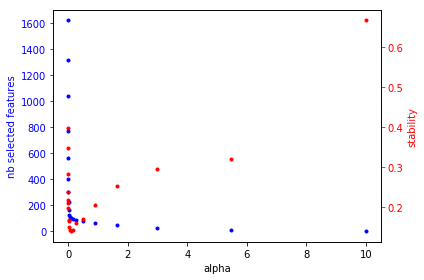

In [110]:
fig, ax1 = plt.subplots()
ax1.plot(alphas, list_nb_selected_features, 'b.')
ax1.set_xlabel('alpha')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('nb selected features', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(alphas, list_stability, 'r.')
ax2.set_ylabel('stability', color='r')
ax2.tick_params('y', colors='r')
# ax2.set_xlim([0,0.05]) # uncomment this line

fig.tight_layout()
plt.show()

The jaccard index is high for extreme situation (when none or all features is selected). 

The Kuncheva's ConcordenceIndex adresses this issue. [link to paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.101.6458&rep=rep1&type=pdf])

In [126]:
# Kuncheva's CI
def consistency_index(sel1, sel2, num_features):                                                 
    observed = float(len(sel1.intersection(sel2)))                                               
    expected = len(sel1) * len(sel2) / float(num_features)                                       
    maxposbl = float(min(len(sel1), len(sel2)))               
    if expected == maxposbl:                                                                     
        return 0                                                                                 
    return (observed - expected) / (maxposbl - expected)

def compute_CI(stability, selected_features):
    #all_selected_features = []
    #for j in range(nb_fold):
        # WARNING: list concatenation with '+' works only with Python3
    #    all_selected_features.append(np.where(selected_features[j]!=0)[0].tolist())
    #all_selected_features = list(np.union1d(all_selected_features))
    num_features = len(selected_features[0])
    for j in range(nb_fold):
        selected_features[j] = set(np.where(selected_features[j]!=0)[0])
    return stability + [[consistency_index(selected_features[j], selected_features[k], num_features)
                         for j in range(nb_fold-1) for k in range(j+1,nb_fold)]]

In [127]:
list_CI, list_nb_selected_features = [], []
for alpha in alphas:
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=92)
    kf.get_n_splits(X_2W_tr)
    nb_selected_features, selected_features, CI = [], [], []
    for train_index, test_index in kf.split(X_2W_tr):
        coef = linear_model.Lasso(alpha=alpha, fit_intercept=True).fit(
            X_2W_tr[train_index,:], y_2W_tr[train_index]).coef_
        selected_features = get_selected_feature(selected_features, coef)
        nb_selected_features.append(len(np.where(coef!=0)[0]))
    CI = compute_CI(CI, selected_features)
    list_CI.append(np.mean(CI))
    list_nb_selected_features.append(np.mean(nb_selected_features))

/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


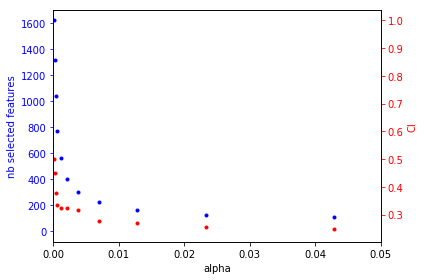

In [128]:
fig, ax1 = plt.subplots()
ax1.plot(alphas, list_nb_selected_features, 'b.')
ax1.set_xlabel('alpha')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('nb selected features', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(alphas, list_CI, 'r.')
ax2.set_ylabel('CI', color='r')
ax2.tick_params('y', colors='r')
ax2.set_xlim([0,0.05]) # uncomment this line

fig.tight_layout()
plt.show()

## Elastic net

One solution to make the lasso more stable is to use a combination of the l1 and l2 regularizations.

We are now minimizing the loss + a linear combination of an l1-norm and an l2-norm over the regression weights. This imposes sparsity, but encourages correlated features to be selected together, where the lasso would tend to pick only one (at random) of a group of correlated features.

The elastic net is implemented in scikit-learn's [linear_model.ElasticNet](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet).

In [34]:
# Parameters grid
alphas = np.logspace(-4., 1., num=15)
ratios = np.linspace(0.5, 1., num=3)

In [35]:
enet = linear_model.ElasticNet(fit_intercept=True)
model_l1l2 = model_selection.GridSearchCV(enet, 
                                        param_grid={'alpha': alphas, 
                                                    'l1_ratio': ratios}, 
                                        scoring='explained_variance')
model_l1l2.fit(X_2W_tr, y_2W_tr)

/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

GridSearchCV(cv=None, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'l1_ratio': array([0.5 , 0.75, 1.  ]), 'alpha': array([1.00000e-04, 2.27585e-04, 5.17947e-04, 1.17877e-03, 2.68270e-03,
       6.10540e-03, 1.38950e-02, 3.16228e-02, 7.19686e-02, 1.63789e-01,
       3.72759e-01, 8.48343e-01, 1.93070e+00, 4.39397e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='explained_variance', verbose=0)

(0, 9419)

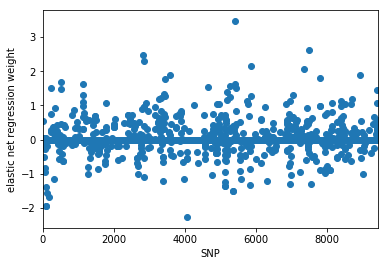

In [36]:
plt.figure(figsize=(6, 4))
plt.scatter(range(p), # x = SNP position
            model_l1l2.best_estimator_.coef_)  # y = regression weights

plt.xlabel("SNP")
plt.ylabel("elastic net regression weight")
plt.xlim([0, p])

__How can you interpret these results? How many SNPs contribute to explaining the phenotype?__

In [247]:
print("%d SNPs selected." % \
    np.nonzero(model_l1l2.best_estimator_.coef_)[0].shape)
l1l1_selected_genes = np.where(model_l1l2.best_estimator_.coef_!=0)[0].tolist()

583 SNPs selected.


### Predictive power 

In [42]:
y_2W_l1l2_pred = model_l1l2.best_estimator_.predict(X_2W_te)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
     (np.nonzero(model_l1l2.best_estimator_.coef_)[0].shape[0], 
      metrics.explained_variance_score(y_2W_te, y_2W_l1l2_pred)))

Percentage of variance explained (using 583 SNPs): 0.76


(13.95, 125.05)

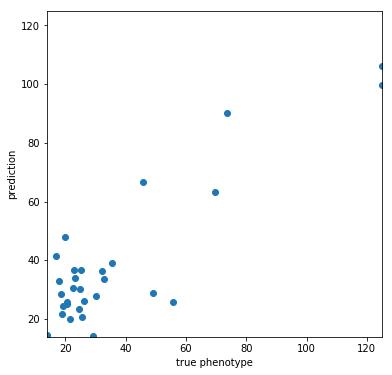

In [43]:
plt.figure(figsize=(6, 6))
plt.scatter(y_2W_te, y_2W_l1l2_pred)

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_te)-0.05, np.max(y_2W_te)+0.05])
plt.ylim([np.min(y_2W_te)-0.05, np.max(y_2W_te)+0.05])

### Stability

__How stable is the set of selected SNPs, between the different rounds of cross-validation with optimal parameters?__

In [40]:
from sklearn import model_selection

random_states = [92,501,13,98,173,803,455,2948,999,234]
stability = []
nb_fold = 3
for i in range(3):
    kf = model_selection.KFold(n_splits=nb_fold, shuffle=True, random_state=random_states[i])
    kf.get_n_splits(X_2W_tr)
    selected_features = []
    for train_index, test_index in kf.split(X_2W_tr):
        coef = linear_model.ElasticNet(alpha=model_l1l2.best_params_['alpha'], 
                                       l1_ratio=model_l1l2.best_params_['l1_ratio'], 
                                       fit_intercept=True, max_iter=5000).fit(
            X_2W_tr[train_index,:], y_2W_tr[train_index]).coef_
        selected_features = get_selected_feature(selected_features, coef)
    stability = compute_stability(stability, selected_features)
    
print(np.mean(stability))

0.1491556744001557


## Stability selection with the Lasso

__Use a randomized procedure to stabilize the lasso__

[sklearn.linear_model.RandomizedLasso.html](http://scikit-learn.org/0.18/modules/generated/sklearn.linear_model.RandomizedLasso.html#sklearn.linear_model.RandomizedLasso) + [User Guide](http://scikit-learn.org/0.18/auto_examples/linear_model/plot_sparse_recovery.html)

In [206]:
scaling = 0.5

randlasso = linear_model.RandomizedLasso(
    alpha=model_l1.best_params_['alpha'], sample_fraction=0.75, n_resampling=200, scaling=scaling)
randlasso.fit(X_2W_tr, y_2W_tr)

/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


RandomizedLasso(alpha=0.012742749857031334, eps=2.220446049250313e-16,
        fit_intercept=True, max_iter=500, memory=None, n_jobs=1,
        n_resampling=200, normalize=True, pre_dispatch='3*n_jobs',
        precompute='auto', random_state=None, sample_fraction=0.75,
        scaling=0.5, selection_threshold=0.25, verbose=False)

**Note**: It is usually more relevant to evaluate the range of relevant selection_threshold to be tested depending on the number of selected features per threshold.  We can change with `randlasso.selection_threshold = new_value`.

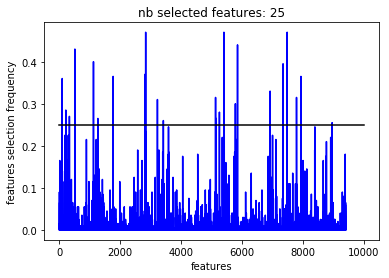

In [253]:
randlasso.selection_threshold = 0.25
plt.plot(np.arange(X_2W_tr.shape[1]), randlasso.scores_, 'b')
plt.plot([0,10000], [randlasso.selection_threshold, randlasso.selection_threshold], 'k')
plt.xlabel("features")
plt.ylabel("features selection frequency")
plt.title('nb selected features: %d' % sum(randlasso.scores_ >= randlasso.selection_threshold))

In [259]:
randlasso_selected_genes = [ind for ind in range(len(randlasso.scores_)) 
                            if randlasso.scores_[ind] >= randlasso.selection_threshold]

In [208]:
X_2W_tr_cut, X_2W_te_cut = randlasso.transform(X_2W_tr), randlasso.transform(X_2W_te)
print(X_2W_tr_cut.shape)

(121, 25)


### Predictive power 

In [209]:
y_2W_randlasso_pred =linear_model.LinearRegression(fit_intercept=True).fit(X_2W_tr_cut, y_2W_tr).predict(X_2W_te_cut)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
     (sum(randlasso.scores_ >= randlasso.selection_threshold), 
      metrics.explained_variance_score(y_2W_te, y_2W_randlasso_pred)))

Percentage of variance explained (using 25 SNPs): 0.42


(13.95, 125.05)

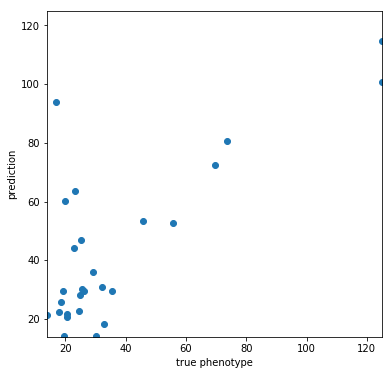

In [210]:
plt.figure(figsize=(6, 6))
plt.scatter(y_2W_te, y_2W_randlasso_pred)

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_te)-0.05, np.max(y_2W_te)+0.05])
plt.ylim([np.min(y_2W_te)-0.05, np.max(y_2W_te)+0.05])

### Selecting a nb of features

In [228]:
nb_features = 500

feature_frequency = randlasso.scores_
coef = np.zeros(X_2W_tr.shape[1])
for j, ind in enumerate(np.argsort(feature_frequency)[::-1].tolist()):
    if j <= nb_features:
        randlasso.selection_threshold = feature_frequency[ind]
    else:
        break

In [229]:
randlasso.selection_threshold

0.025

In [230]:
X_2W_tr_cut, X_2W_te_cut = randlasso.transform(X_2W_tr), randlasso.transform(X_2W_te)
print(X_2W_tr_cut.shape)

(121, 455)


In [231]:
y_2W_randlasso_pred =linear_model.LinearRegression(fit_intercept=True).fit(X_2W_tr_cut, y_2W_tr).predict(X_2W_te_cut)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
     (sum(randlasso.scores_ >= randlasso.selection_threshold), 
      metrics.explained_variance_score(y_2W_te, y_2W_randlasso_pred)))

Percentage of variance explained (using 549 SNPs): 0.76


### Stability

__How stable is the set of selected SNPs, between the different rounds of cross-validation with optimal parameters?__

In [233]:
# feature stability with 100 features
from sklearn import model_selection

nb_features = 500

random_states = [92,501,13,98,173,803,455,2948,999,234]
stability = []
nb_fold = 3
for i in range(1):
    kf = model_selection.KFold(n_splits=nb_fold, shuffle=True, random_state=random_states[i])
    kf.get_n_splits(X_2W_tr)
    selected_features = []
    for train_index, test_index in kf.split(X_2W_tr):
        model = linear_model.RandomizedLasso(alpha=model_l1.best_params_['alpha'], sample_fraction=0.75, 
                                             n_resampling=200, scaling=0.5).fit(X_2W_tr[train_index,:], 
                                                                                y_2W_tr[train_index])
        feature_frequency = model.scores_
        coef = np.zeros(X_2W_tr.shape[1])
        for j, ind in enumerate(np.argsort(feature_frequency)[::-1]):
            if j < nb_features:
                coef[ind] = 1
            else:
                break
        selected_features = get_selected_feature(selected_features, coef)
    stability = compute_stability(stability, selected_features)
    
print(np.mean(stability))

/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


0.19073182484214082


## Network-constrained lasso

This is not implemented in scikit-learn, so we'll need to create our own estimator.

It turns out that it is possible to transform the network-constrained Lasso problem into a Lasso problem: follow [the original paper](https://academic.oup.com/bioinformatics/article/24/9/1175/206444) (pdf also available [here](http://www.stat.purdue.edu/~doerge/BIOINFORM.D/FALL10/Li_and_Li_2008_Bioinformatics.pdf) and the note in section C of [the supplementary material of Sugiyama et al. (2014)](http://cazencott.info/dotclear/public/publications/sugiyama2014_supp.pdf) to replace the eigen-decomposition of the graph Laplacian with the graph incidence matrix.

Follow the [documentation](http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator) or this [blog post](http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/) to create a scikit-learn estimator.

Be careful: the computations might require a lot of RAM.

### Load the network

In [91]:
from scipy import sparse

In [92]:
w_saved = np.loadtxt('data/athaliana_small.W.txt')

In [93]:
w_saved.shape

(3, 1291643)

In [94]:
# 1291643 is the number of connection between genes for athaliana's gene network
# w_saved[0,:] correspond to the list of row indices
# w_saved[1,:] correspond to the list of column indices
# w_saved[1,:] if full of 1
W = sparse.coo_matrix((w_saved[2, :], (np.array(w_saved[0, :], dtype=int), 
                                       np.array(w_saved[1, :], dtype=int))), 
                      shape=(p, p))

**Note to authors:** we don't know what gene network it is

### Build the incidence matrix

In [95]:
# Compute node degrees 
degrees = np.zeros((p, ))
for vertex in W.row:
    degrees[vertex] += 2

**Note to authors:** why 2 and not 1 is added per connections ?

In [96]:
# build the incidence matrix linking each vertex to its connected edges
tim = sparse.lil_matrix((W.row.shape[0], p))
for ix, edge in enumerate(W.data):
    tim[ix, W.row[ix]] = np.sqrt(edge / degrees[W.row[ix]])
    tim[ix, W.col[ix]] = - np.sqrt(edge / degrees[W.col[ix]])

In [97]:
tim.shape

(1291643, 9419)

### Create the network-constrained Lasso class

In [98]:
from sklearn import base, linear_model

In [99]:
class ncLasso(base.BaseEstimator, base.RegressorMixin):
    def __init__(self, transposed_incidence=None, lambda1=1.0, lambda2=1.0):
        self.transposed_incidence = transposed_incidence # sparse matrix
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        
    def fit(self, X, y):       
        alpha = self.lambda1/(np.sqrt(self.lambda2+1.))
        self.lasso = linear_model.Lasso(fit_intercept=True, alpha=alpha)
        
        
        y_new = np.hstack((y, np.zeros((self.transposed_incidence.shape[0], ))))
        print(y_new.shape, X.shape)
        X_new = 1/(np.sqrt(self.lambda2+1)) * sparse.vstack((X, np.sqrt(self.lambda2)*\
                                                    self.transposed_incidence))
        
        
        self.lasso.fit(X_new, y_new)
        self.coef_ = self.lasso.coef_[:X.shape[1]]/(np.sqrt(self.lambda2+1))
        return self
        
        
    def predict(self, X, y=None):
        return self.lasso.predict(X)
    
    
    def score(self, X, y=None):
        return self.lasso.score(X, y)                                        

__Use the network-constrained Lasso on the data. What do you observe?__

In [100]:
nclasso = ncLasso(transposed_incidence=tim, lambda1=0.001, lambda2=0.001)
nclasso.fit(X_2W_tr, y_2W_tr)

(1291764,) (121, 9419)


ncLasso(lambda1=0.001, lambda2=0.001,
    transposed_incidence=<1291643x9419 sparse matrix of type '<class 'numpy.float64'>'
	with 2582679 stored elements in LInked List format>)

In [101]:
y_2W_nclasso_pred = nclasso.predict(X_2W_te)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
     (np.nonzero(nclasso.coef_)[0].shape[0], 
      metrics.explained_variance_score(y_2W_te, y_2W_nclasso_pred)))

Percentage of variance explained (using 19 SNPs): 0.19


__Print the selected genes within the gene network__

In [261]:
nclasso_selected_genes = np.where(nclasso.coef_!=0)[0].tolist()

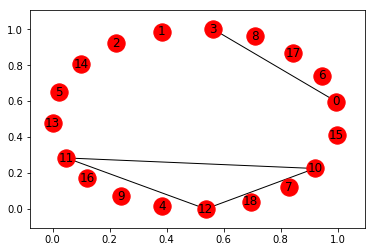

In [262]:
import networkx as nx

selected_genes = nclasso_selected_genes # try with randlasso_selected_genes

nb_selected_genes = len(selected_genes)

adjacency_matrix = np.zeros((nb_selected_genes, nb_selected_genes))
for i_gene, gene in enumerate(selected_genes):
    ind_of_interest = np.where(w_saved[0,:]==gene)[0]
    for ind in ind_of_interest:
        if w_saved[1,ind] in selected_genes:
            j_gene = selected_genes.index(w_saved[1,ind])
            adjacency_matrix[i_gene, j_gene] = 1
            adjacency_matrix[j_gene, i_gene] = 1

G1=nx.from_numpy_matrix(adjacency_matrix)
graph_pos=nx.spring_layout(G1,k=0.50,iterations=50)
nx.draw_networkx(G1,graph_pos)

**Note:** it would be also interesting to change node radius depending on its associated weight, to associate a color to each node depending on they are associated to some biological pathways etc

## Multi-task feature selection

1) Repeat the previous analysis for the 4W phenotype. It is very similar to the 2W phenotype, except that the seeds have been vernelized for 4 weeks. 

2) It is not unreasonable to expect the genomic regions driving both those phenotypes to be (almost) the same. Use the multi-task version of the Lasso, ENet, or ncLasso algorithms to analyzed both phenotypes simultaneously.

Use [sklearn.linear_model.MultiTaskLasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskLasso.html#sklearn.linear_model.MultiTaskLasso) + [User Guide](http://scikit-learn.org/stable/auto_examples/linear_model/plot_multi_task_lasso_support.html)

**Note to authors:** we may let a empty cells for the student who will reach this point 

In [55]:
df = pd.read_csv('data/phenotypes.pheno', sep=' ')
df_2W = df['2W']
df_4W = df['4W']
samples_with_phenotype_temp = np.where(pd.isnull(df_2W)!=True)[0].tolist() + np.where(pd.isnull(df_4W)!=True)[0].tolist()
samples_with_phenotype = []
for s in samples_with_phenotype_temp:
    if samples_with_phenotype_temp.count(s) > 1 and s not in samples_with_phenotype:
        samples_with_phenotype.append(s)

In [56]:
X_2W_4W = X[samples_with_phenotype, :]
y_2W_4W = np.array([np.array(df_2W)[samples_with_phenotype], np.array(df_4W)[samples_with_phenotype]]).transpose()
n, p = X_2W_4W.shape
print(n, p)

117 9419


In [57]:
X_2W_4W_tr, X_2W_4W_te, y_2W_4W_tr, y_2W_4W_te = \
    model_selection.train_test_split(X_2W_4W, y_2W_4W, test_size=0.2, 
                                     random_state=17)
print(X_2W_4W_tr.shape, X_2W_4W_te.shape)

(93, 9419) (24, 9419)


In [58]:
alphas = np.logspace(-4., 1., num=20)

In [59]:
from sklearn import linear_model
lasso = linear_model.MultiTaskLasso(fit_intercept=True)
model_MTl1 = model_selection.GridSearchCV(lasso, 
                                          param_grid={'alpha': alphas}, 
                                          scoring='explained_variance')
model_MTl1.fit(X_2W_4W_tr, y_2W_4W_tr)

/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:1778: ConvergenceWarning: Objective did not converge, you might want to increase the number of iterations
  ConvergenceWarning)
/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:1778: ConvergenceWarning: Objective did not converge, you might want to increase the number of iterations
  ConvergenceWarning)
/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:1778: ConvergenceWarning: Objective did not converge, you might want to increase the number of iterations
  ConvergenceWarning)
/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:1778: ConvergenceWarning: Objective did not converge, you might want to increase the number of iterations
  ConvergenceWarning)
/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:1778: ConvergenceW

GridSearchCV(cv=None, error_score='raise',
       estimator=MultiTaskLasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
        normalize=False, random_state=None, selection='cyclic', tol=0.0001,
        warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-04, 1.83298e-04, 3.35982e-04, 6.15848e-04, 1.12884e-03,
       2.06914e-03, 3.79269e-03, 6.95193e-03, 1.27427e-02, 2.33572e-02,
       4.28133e-02, 7.84760e-02, 1.43845e-01, 2.63665e-01, 4.83293e-01,
       8.85867e-01, 1.62378e+00, 2.97635e+00, 5.45559e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='explained_variance', verbose=0)

In [86]:
# we can check that non-selected features are the same for both tasks
selected_features_2W, selected_features_4W = \
    np.where(model_MTl1.best_estimator_.coef_[0,:])[0], np.where(model_MTl1.best_estimator_.coef_[1,:])[0]
all(np.intersect1d(selected_features_2W, selected_features_4W) == np.union1d(selected_features_2W, selected_features_4W))

True

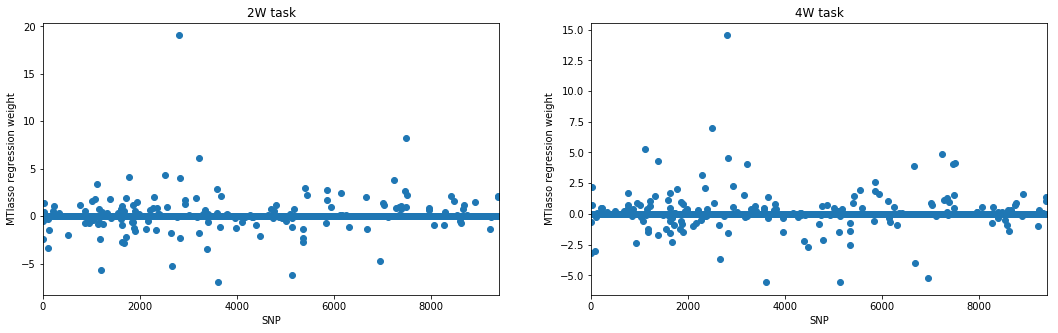

In [74]:
plt.figure(figsize=(18, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.scatter(range(p), # x = SNP position
                model_MTl1.best_estimator_.coef_[i,:])  # y = regression weights
    plt.xlabel("SNP")
    plt.ylabel("MTlasso regression weight")
    title = '2W task' if i==0 else '4W task'
    plt.title(title)
    plt.xlim([0, p])

__How can you interpret these results? How many SNPs contribute to explaining the phenotype?__

In [61]:
print("%d SNPs selected." % \
    np.nonzero(model_MTl1.best_estimator_.coef_)[0].shape)

412 SNPs selected.


### Predictive power 

In [62]:
from sklearn import metrics
y_2W_4W_MTl1_pred = model_MTl1.best_estimator_.predict(X_2W_4W_te)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
     (np.nonzero(model_MTl1.best_estimator_.coef_)[0].shape[0], 
      metrics.explained_variance_score(y_2W_4W_te, y_2W_4W_MTl1_pred)))

Percentage of variance explained (using 412 SNPs): 0.75


(14.95, 125.05)

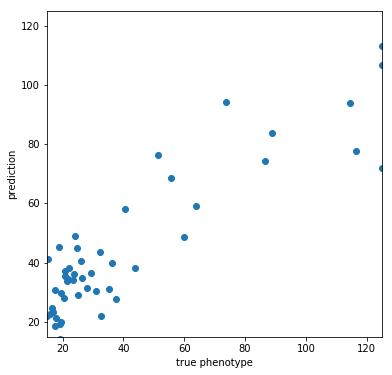

In [63]:
plt.figure(figsize=(6, 6))
plt.scatter(y_2W_4W_te, y_2W_4W_MTl1_pred)

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_4W_te)-0.05, np.max(y_2W_4W_te)+0.05])
plt.ylim([np.min(y_2W_4W_te)-0.05, np.max(y_2W_4W_te)+0.05])

### Stability

__How stable is the set of selected SNPs, between the different rounds of cross-validation with optimal parameters?__

You can use [sklearn.metrics.jaccard_similarity_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_similarity_score.html), or implement Kuncheva's consistency index.

In [64]:
from sklearn import model_selection

random_states = [92,501,13,98,173,803,455,2948,999,234]
stability = []
nb_fold = 3
for i in range(3):
    kf = model_selection.KFold(n_splits=nb_fold, shuffle=True, random_state=random_states[i])
    kf.get_n_splits(X_2W_4W_tr)
    selected_features = []
    for train_index, test_index in kf.split(X_2W_4W_tr):
        coef = linear_model.MultiTaskLasso(alpha=model_MTl1.best_params_['alpha'], fit_intercept=True, max_iter=1000).fit(
            X_2W_4W_tr[train_index,:], y_2W_4W_tr[train_index]).coef_
        selected_features = get_selected_feature(selected_features, coef)
    stability = compute_stability(stability, selected_features)
    
print(np.mean(stability))

/home/beubeu/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:1778: ConvergenceWarning: Objective did not converge, you might want to increase the number of iterations
  ConvergenceWarning)


0.07524409651875423
